###Linear regression

In [3]:
#import
import numpy as np
import pandas as pd

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [4]:
#load datasets
X_train = pd.read_csv("X_train_scaled.csv")
X_test = pd.read_csv("X_test_scaled.csv")

y_train = pd.read_csv("y_train.csv")
y_test = pd.read_csv("y_test.csv")

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (1020, 874)
X_test shape: (255, 874)
y_train shape: (1020, 1)
y_test shape: (255, 1)


In [5]:
#function for evaluation
def evaluate_regression(model_name, y_true_train, y_pred_train, y_true_test, y_pred_test):
    #train metrics
    mse_train = mean_squared_error(y_true_train, y_pred_train)
    rmse_train = np.sqrt(mse_train)
    mae_train = mean_absolute_error(y_true_train, y_pred_train)
    r2_train = r2_score(y_true_train, y_pred_train)

    #test metrics
    mse_test = mean_squared_error(y_true_test, y_pred_test)
    rmse_test = np.sqrt(mse_test)
    mae_test = mean_absolute_error(y_true_test, y_pred_test)
    r2_test = r2_score(y_true_test, y_pred_test)

    print(f"=== {model_name} ===")
    print("Train:")
    print(f"  MSE  = {mse_train:.4f}")
    print(f"  RMSE = {rmse_train:.4f}")
    print(f"  MAE  = {mae_train:.4f}")
    print(f"  R^2  = {r2_train:.4f}")
    print("Test:")
    print(f"  MSE  = {mse_test:.4f}")
    print(f"  RMSE = {rmse_test:.4f}")
    print(f"  MAE  = {mae_test:.4f}")
    print(f"  R^2  = {r2_test:.4f}")
    print()

###Neural Network

In [6]:
#import
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping


In [7]:
#flatten for NN
y_train_nn = y_train.values.ravel()
y_test_nn = y_test.values.ravel()

Start Hyperparameter Tuning...
Testing Learning Rate: 0.01


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Testing Learning Rate: 0.001


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Testing Learning Rate: 0.0001


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Testing Learning Rate: 1e-05


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


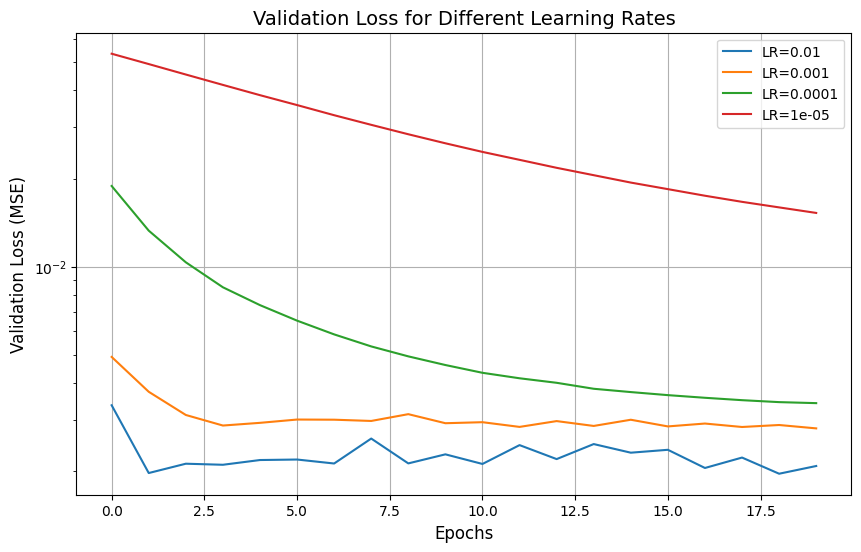

Based on the tuning run, the best Learning Rate is: 0.01


In [8]:
#apply hyperparameter tuning for best learning rate & early stopping for better performance

#switch for learning rate tuning and early stopping (can be set to false for original result)
LR_TUNING = True
EARLY_STOPPING = True

#default learning rate
best_lr = 0.001

if LR_TUNING:
    learning_rates = [0.01, 0.001, 0.0001, 0.00001]
    histories = {}
    print("Start Hyperparameter Tuning...")

    for lr in learning_rates:
        print(f"Testing Learning Rate: {lr}")

        model_tune = Sequential([
            Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
            Dense(32, activation='relu'),
            Dense(1)
        ])

        model_tune.compile(optimizer=Adam(learning_rate=lr), loss='mse')

        history_tune = model_tune.fit(
            X_train,
            y_train_nn,
            validation_split=0.2,
            epochs=20,
            batch_size=32,
            verbose=0
        )
        histories[lr] = history_tune.history['val_loss']

    #pick best LR by lowest final validation loss
    min_val_loss = float('inf')
    for lr, val_loss_history in histories.items():
        final_loss = val_loss_history[-1]
        if final_loss < min_val_loss:
            min_val_loss = final_loss
            best_lr = lr

    #optional plot
    import matplotlib.pyplot as plt
    plt.figure(figsize=(10, 6))
    for lr, val_loss_history in histories.items():
        plt.plot(val_loss_history, label=f'LR={lr}')
    plt.title('Validation Loss for Different Learning Rates', fontsize=14)
    plt.xlabel('Epochs', fontsize=12)
    plt.ylabel('Validation Loss (MSE)', fontsize=12)
    plt.legend()
    plt.grid(True)
    plt.yscale('log')
    plt.show()

    print(f"Based on the tuning run, the best Learning Rate is: {best_lr}")

#Early stopping callback
early_stop_cb = None
if EARLY_STOPPING:
    early_stop_cb = EarlyStopping(
        monitor='val_loss',
        patience=20,
        mode='min',
        restore_best_weights=True
    )


In [9]:
#NN definition: Two hidden layers (64, 32), ReLU activation, single regression output
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(32, activation='relu'),
    Dense(1)  # regression output
])

model.compile(
    optimizer=Adam(learning_rate=best_lr),
    loss='mse'
)

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_12 (Dense)                │ (None, 64)             │        56,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 58,113 (227.00 KB)

 Trainable params: 58,113 (227.00 KB)

 Non-trainable params: 0 (0.00 B)

In [10]:
#train with split for validation
history = model.fit(
    X_train,
    y_train_nn,
    validation_split=0.2,
    epochs=30,
    batch_size=32,
    verbose=1,
    callbacks=([early_stop_cb] if early_stop_cb is not None else None)
)

Epoch 1/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0215 - val_loss: 0.0042
Epoch 2/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0028 - val_loss: 0.0024
Epoch 3/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0014 - val_loss: 0.0021
Epoch 4/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 8.3048e-04 - val_loss: 0.0022
Epoch 5/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.6407e-04 - val_loss: 0.0022
Epoch 6/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.0226e-04 - val_loss: 0.0021
Epoch 7/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.0507e-04 - val_loss: 0.0021
Epoch 8/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.7796e-04 - val_loss: 0.0020
Epoch 9/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.1129e-04 - val_loss: 0.0020
Epoch 10/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.5946e-04 - val_loss: 0.0022
Epoch 11/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.3550e-04 - val_loss: 0.0019
Epoch 12/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s

In [11]:
#prediction & evaluation
y_train_pred_nn = model.predict(X_train).ravel()
y_test_pred_nn = model.predict(X_test).ravel()

#metrics
mse_train_nn = mean_squared_error(y_train_nn, y_train_pred_nn)
rmse_train_nn = np.sqrt(mse_train_nn)
mae_train_nn = mean_absolute_error(y_train_nn, y_train_pred_nn)
r2_train_nn = r2_score(y_train_nn, y_train_pred_nn)

mse_test_nn = mean_squared_error(y_test_nn, y_test_pred_nn)
rmse_test_nn = np.sqrt(mse_test_nn)
mae_test_nn = mean_absolute_error(y_test_nn, y_test_pred_nn)
r2_test_nn = r2_score(y_test_nn, y_test_pred_nn)

print("=== Neural Network Regression ===")
print("Train:")
print(f"  MSE  = {mse_train_nn:.4f}")
print(f"  RMSE = {rmse_train_nn:.4f}")
print(f"  MAE  = {mae_train_nn:.4f}")
print(f"  R^2  = {r2_train_nn:.4f}")
print("Test:")
print(f"  MSE  = {mse_test_nn:.4f}")
print(f"  RMSE = {rmse_test_nn:.4f}")
print(f"  MAE  = {mae_test_nn:.4f}")
print(f"  R^2  = {r2_test_nn:.4f}")

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
=== Neural Network Regression ===
Train:
  MSE  = 0.0005
  RMSE = 0.0232
  MAE  = 0.0135
  R^2  = 0.9612
Test:
  MSE  = 0.0016
  RMSE = 0.0403
  MAE  = 0.0275
  R^2  = 0.8849


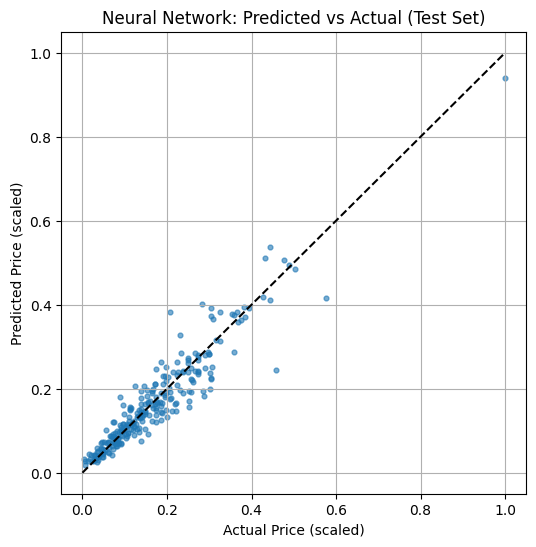

In [12]:
#visualization
plt.figure(figsize=(6,6))

plt.plot([0,1], [0,1], 'k--', label='Perfect fit')
plt.scatter(y_test_nn, y_test_pred_nn, s=12, alpha=0.6)

plt.xlabel("Actual Price (scaled)")
plt.ylabel("Predicted Price (scaled)")
plt.title("Neural Network: Predicted vs Actual (Test Set)")
plt.grid(True)
plt.show()

Result Summary:

Trained a simple feedforward neural network on the scaled feature set using two hidden layers. The model learned the training data well and reached a test R² of around 0.8, showing that it was able to capture some nonlinear relationships in the dataset. However, its performance was still below Ridge regression, the high-dimensional sparse input space and limited data size make regularized linear models more effective for this task than NN.

After learning rate tuning and early stopping, the neural network achieved noticeably better performance, reaching a test R² of approximately 0.89. The gap between training and test metrics was reduced, suggesting improved generalization compared to the untuned model.